## Оптимизация выполнения кода, векторизация, Numba

Материалы:
* Макрушин С.В. Лекция 3: Оптимизация выполнения кода, векторизация, Numba
* IPython Cookbook, Second Edition (2018), глава 4
* https://numba.pydata.org/numba-doc/latest/user/5minguide.html

## Задачи для совместного разбора

1. Сгенерируйте массив `A` из `N=1млн` случайных целых чисел на отрезке от 0 до 1000. Пусть `B[i] = A[i] + 100`. Посчитайте среднее значение массива `B`.

In [23]:
import pandas as pd
import numpy as np
import random
import string
import numba


In [24]:
%load_ext line_profiler

In [25]:
A = np.random.randint(0,1000, size=(1000000,))
B = [a + 100 for a in A]
mean_B = sum(B) / 1000000

print(mean_B)

599.100801


2. Создайте таблицу 2млн строк и с 4 столбцами, заполненными случайными числами. Добавьте столбец `key`, которые содержит элементы из множества английских букв. Выберите из таблицы подмножество строк, для которых в столбце `key` указаны первые 5 английских букв.

In [26]:
df = pd.DataFrame(np.random.randint(0, 1000, size=(2000000, 4)), columns=list('ABCD'))
df['key'] = random.choices(string.ascii_lowercase, k=2000000)
subset = df[df['key'].str[:5].isin(list(string.ascii_lowercase)[:5])]
print(subset.head())


      A    B    C    D key
2   176  517  810  746   a
13  286  872  963   51   a
22  459  368   26   12   a
23  815  787  287  416   c
27  130  833  588  483   e


## Лабораторная работа 3

In [7]:
# !pip install line_profiler

1. В файлах `recipes_sample.csv` и `reviews_sample.csv` (__ЛР 2__) находится информация об рецептах блюд и отзывах на эти рецепты соответственно. Загрузите данные из файлов в виде `pd.DataFrame` с названиями `recipes` и `reviews`. Обратите внимание на корректное считывание столбца(ов) с индексами. Приведите столбцы к нужным типам.

Реализуйте несколько вариантов функции подсчета среднего значения столбца `rating` из таблицы `reviews` для отзывов, оставленных в 2010 году.

A. С использованием метода `DataFrame.iterrows` исходной таблицы;

Б. С использованием метода `DataFrame.iterrows` таблицы, в которой сохранены только отзывы за 2010 год;

В. С использованием метода `Series.mean`.

Проверьте, что результаты работы всех написанных функций корректны и совпадают. Измерьте выполнения всех написанных функций.


In [27]:
import pandas as pd
import time


In [28]:
recipes = pd.read_csv("recipes_sample.csv", sep=",", parse_dates=['submitted'])
recipes = recipes.set_index('id')

reviews = pd.read_csv("reviews_sample.csv", sep=",",parse_dates=['date'])
reviews.rename(columns={'Unnamed: 0': 'id'}, inplace=True)
reviews = reviews.set_index('id')

reviews['date'] = pd.to_datetime(reviews['date'])
reviews['rating'] = reviews['rating'].astype(float)

In [29]:
def rating_A(reviews):
    start_time = time.time()
    total = 0
    count = 0
    for index, row in reviews.iterrows():
        if row['date'].year == 2010:
            total += row['rating']
            count += 1
    full_time = time.time() - start_time
    return "Cр.знач:",total/count,"Время:",full_time
rating_A(reviews)


('Cр.знач:', 4.4544402182900615, 'Время:', 13.878585577011108)

In [12]:
def rating_B(reviews):
    start_time = time.time()
    reviews_2010 = reviews[reviews['date'].dt.year == 2010]
    total = 0
    count = 0
    for index, row in reviews_2010.iterrows():
        total += row['rating']
        count += 1
    full_time = time.time() - start_time
    return "Cр.знач:",total/count,"Время:",full_time
rating_B(reviews)


('Cр.знач:', 4.4544402182900615, 'Время:', 1.362023115158081)

In [13]:
def rating_C(reviews):
    start_time = time.time()
    reviews_2010 = reviews[reviews['date'].dt.year == 2010]
    answer = reviews_2010['rating'].mean()
    full_time = time.time() - start_time
    return "Cр.знач:",answer,"Время:",full_time
rating_C(reviews)


('Cр.знач:', 4.4544402182900615, 'Время:', 0.028270244598388672)

2. Какая из созданных функций выполняется медленнее? Что наиболее сильно влияет на скорость выполнения? Для ответа использовать профайлер `line_profiler`. Сохраните результаты работы профайлера в отдельную текстовую ячейку и прокомментируйте результаты его работы.

(*). Сможете ли вы ускорить работу функции 1Б, отказавшись от использования метода `iterrows`, но не используя метод `mean`?

In [39]:
%lprun -f rating_A rating_A(reviews)

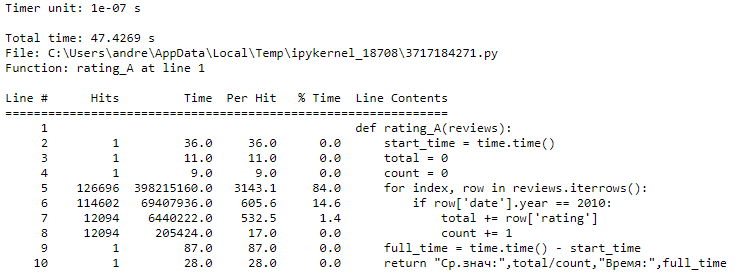

Дольше всего выполняется цикл for.

In [14]:
def rating_4():
    start_time = time.time()
    data = np.matrix((reviews["rating"], reviews["date"].dt.year), dtype=int)
    mask = data[1,] == 2010
    faster_values = np.where(mask, data, 0)
    answer = faster_values[0,].sum() / mask.sum()
    full_time = time.time() - start_time
    return "Cр.знач:",answer,"Время:",full_time
rating_4()

('Cр.знач:', 4.4544402182900615, 'Время:', 0.021315574645996094)

3. Вам предлагается воспользоваться функцией, которая собирает статистику о том, сколько отзывов содержат то или иное слово. Измерьте время выполнения этой функции. Сможете ли вы найти узкие места в коде, используя профайлер? Выпишите (словами), что в имеющемся коде реализовано неоптимально. Оптимизируйте функцию и добейтесь значительного (как минимум, на один порядок) прироста в скорости выполнения.

In [15]:
def get_word_reviews_count(df):
    word_reviews = {}
    for _, row in reviews.dropna(subset=['review']).iterrows():
        recipe_id, review = row['recipe_id'], row['review']
        words = review.split(' ')
        for word in words:
            if word not in word_reviews:
                word_reviews[word] = []
            word_reviews[word].append(recipe_id)
    
    word_reviews_count = {}
    for _, row in reviews.dropna(subset=['review']).iterrows():
        review = row['review']
        words = review.split(' ')
        for word in words:
            word_reviews_count[word] = len(word_reviews[word])
    return word_reviews_count
    
get_word_reviews_count(reviews)


{'Last': 94,
 'week': 804,
 'whole': 5628,
 'sides': 312,
 'of': 109029,
 'frozen': 2647,
 'salmon': 729,
 'fillet': 60,
 'was': 88781,
 'on': 34583,
 'sale': 149,
 'in': 61539,
 'my': 44144,
 'local': 561,
 'supermarket,': 10,
 'so': 46090,
 'I': 285147,
 'bought': 1369,
 'tons': 161,
 '(okay,': 5,
 'only': 13965,
 '3,': 48,
 'but': 42513,
 'total': 381,
 'weight': 160,
 'over': 9065,
 '10': 2303,
 'pounds).': 2,
 '': 214145,
 'This': 39448,
 'recipe': 41098,
 'is': 55075,
 'perfect': 4398,
 'for': 121224,
 'fillet,': 14,
 'even': 7878,
 'though': 2314,
 'it': 111175,
 'calls': 520,
 'steaks.': 93,
 'cut': 6688,
 'up': 13585,
 'the': 266050,
 'into': 7031,
 'individual': 314,
 'portions': 156,
 'and': 217849,
 'followed': 4859,
 'instructions': 731,
 'exactly.': 571,
 "I'm": 7145,
 'one': 15086,
 'those': 2287,
 'food': 2413,
 'combining': 74,
 'diets,': 5,
 'left': 4690,
 'out': 23644,
 'white': 3425,
 'wine': 1256,
 'added': 21710,
 'just': 24944,
 'a': 166136,
 'dash': 532,
 'vineg

In [ ]:
%lprun -f get_word_reviews_count get_word_reviews_count(reviews)

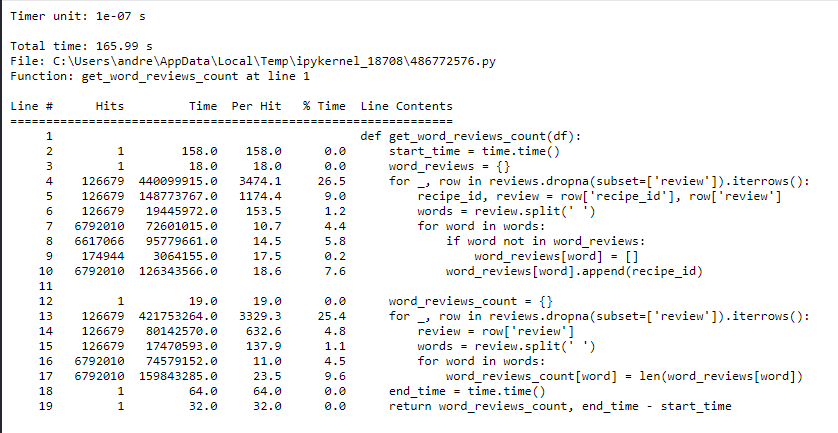

Время выполнения работы = 170 сек
Нет причины дважды заходить в цикл for, можно все сделать через 1.
Дважды создается одна и та же переменная.

In [ ]:
def get_word_reviews_count_optimized(df):
    
    word_reviews = {}
    
    #Удаляем нулевые и проходим идерацией
    for _, row in df.dropna(subset=['review']).iterrows():

        #По каждому слову начинаем цикл
        for word in row['review'].split(' '):
            #Если слово не в словаре, то заносим его
            if word not in word_reviews:
                word_reviews[word] = 0
            #Добавляем рецепт по этому слову
            word_reviews[word] += 1
    
    return word_reviews
get_word_reviews_count_optimized(reviews)


In [ ]:
%lprun -f get_word_reviews_count_optimized get_word_reviews_count_optimized(reviews)

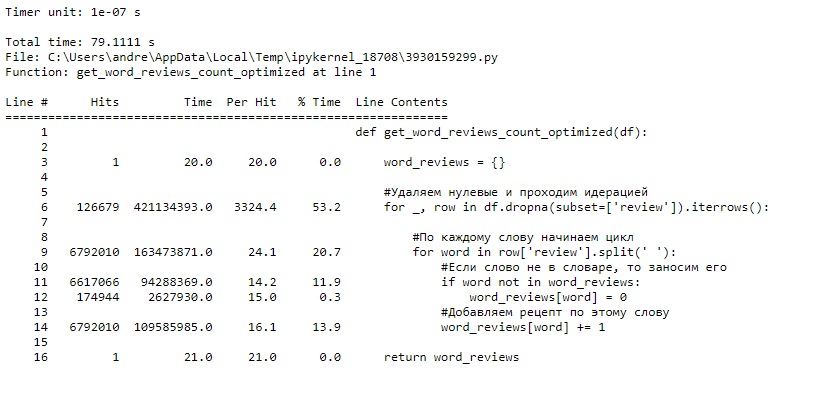

4. Напишите несколько версий функции `MAPE` (см. [MAPE](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error)) для расчета среднего абсолютного процентного отклонения значения рейтинга отзыва на рецепт от среднего значения рейтинга по всем отзывам для этого рецепта. 
    1. Без использования векторизованных операций и методов массивов `numpy` и без использования `numba`
    2. Без использования векторизованных операций и методов массивов `numpy`, но с использованием `numba`
    3. С использованием векторизованных операций и методов массивов `numpy`, но без использования `numba`
    4. C использованием векторизованных операций и методов массивов `numpy` и `numba`
    
Измерьте время выполнения каждой из реализаций.

Замечание: удалите из выборки отзывы с нулевым рейтингом.


In [35]:
reviews['rating'] = reviews['rating'].replace(0, np.nan)  # заменяем нули на пропущенные значения
reviews = reviews.dropna(subset=['rating'])  # удаляем строки с пропущенными значениями


In [5]:
#A
def mape_v1(reviews):
    mape = 0
    for recipe_id in reviews['recipe_id'].unique():
        recipe_reviews = reviews[reviews['recipe_id'] == recipe_id]
        recipe_rating_mean = recipe_reviews['rating'].mean()
        for i, row in recipe_reviews.iterrows():
            mape += abs(row['rating'] - recipe_rating_mean) / recipe_rating_mean
    return mape / len(reviews)
mape_v1(reviews)

0.07951710005387867

In [34]:
%timeit mape_v1(reviews)

59.5 s ± 413 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [37]:
@numba.jit
def mape_v2(recipe_ids, ratings):
    mape = 0
    for recipe_id in np.unique(recipe_ids):
        recipe_reviews_mask = recipe_ids == recipe_id
        recipe_rating_mean = np.mean(ratings[recipe_reviews_mask])
        for i in range(len(recipe_ids)):
            if recipe_reviews_mask[i]:
                mape += np.abs(ratings[i] - recipe_rating_mean) / recipe_rating_mean
    return mape / len(recipe_ids)

recipe_ids = reviews['recipe_id'].values
ratings = reviews['rating'].values

mape_v2(recipe_ids, ratings)


0.07951710005388281

In [39]:
%timeit mape_v2(recipe_ids, ratings)

17.8 s ± 110 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [43]:
#C
def mape_v3(reviews):
    mape = 0.0
    unique_recipe_ids = reviews['recipe_id'].unique()
    for recipe_id in unique_recipe_ids:
        recipe_reviews = reviews[reviews['recipe_id'] == recipe_id]
        recipe_rating_mean = recipe_reviews['rating'].mean()
        mape += np.sum(np.abs(recipe_reviews['rating'] - recipe_rating_mean) / recipe_rating_mean)
    return mape / len(reviews)

mape_v3(reviews)


0.07951710005387888

In [ ]:
%timeit mape_v3(reviews)

In [ ]:
@numba.jit
def mape_v4(recipe_ids, ratings):
    mape = 0
    for recipe_id in np.unique(recipe_ids):
        recipe_reviews_mask = recipe_ids == recipe_id
        recipe_rating_mean = np.mean(ratings[recipe_reviews_mask])
        for i in range(len(recipe_ids)):
            if recipe_reviews_mask[i]:
                mape += np.abs(ratings[i] - recipe_rating_mean) / recipe_rating_mean
    return mape / len(recipe_ids)

recipe_ids = reviews['recipe_id'].values
ratings = reviews['rating'].values

mape_v4(recipe_ids, ratings)


In [ ]:
%timeit mape_v4(reviews)

#### [версия 2]
* Уточнены формулировки задач 1, 3, 4